In [1]:
import nd2reader
import pandas as pd
import string
import numpy as np
from scipy import stats
import os
from multiprocessing import Pool
from os.path import splitext,basename
import cv2
from skimage.segmentation import random_walker
# from skimage.data import binary_blobs
from skimage import io,exposure,restoration,filters,morphology,measure
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [15]:
def nd2arr_list(nd_dh,nd_fns):
    arr_list=[]
    for nd_fn in nd_fns:
        nd = nd2reader.Nd2("%s/%s" % (nd_dh,nd_fn))
        for ndi in nd:
            arr_list.append(np.array(ndi))
        del nd
    return arr_list

def nd2vid(nd_fns,nd_dh):
    def arr_list2vid(arr_list,vid_fh):
        dpi = 100
        xpixels, ypixels = 512, 512
        fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
        ax = plt.Axes(fig, [0., 0., 1, 1])
        fig.add_axes(ax)
        ax.set_axis_off()
        ax.set_aspect('equal')
        im = ax.imshow(arr_list[0],cmap='gray')
        # plt.savefig('test.png')
        def update_img(n):
            tmp = arr_list[n]
            im.set_data(tmp)
            return im
        # #legend(loc=0)
        ani = animation.FuncAnimation(fig,update_img,np.arange(1,len(arr_list)),interval=60,blit=False)
        writer = animation.writers['ffmpeg'](fps=4)
        ani.save(vid_fh,writer=writer)#dpi=dpi
    arr_list=nd2arr_list(nd_dh,nd_fns)
    arr_list2vid(arr_list,fh_xls+'.mp4')
    
def nd2kins(nd_fns,nd_dh):
    def raw2phasecorr(arr_list):
        cx = 0.0
        cy = 0.0
        stb_arr_list=[]
        prev_image = np.float32(arr_list[0]) #ref
        for frame in arr_list:
            image = np.float32(frame)
            # TODO: set window around phase correlation
            dp = cv2.phaseCorrelate(prev_image, image)
            cx = cx - dp[0]
            cy = cy - dp[1]
            xform = np.float32([[1, 0, cx], [0, 1, cy]])
            stable_image = cv2.warpAffine(image, xform, dsize=(image.shape[1], image.shape[0]))
            prev_image = image
            #clip sides
            ht,wd=np.shape(stable_image)
            clip=0.25
            lt=int(wd*clip)
            rt=int(wd-wd*clip)
            up=int(ht*clip)
            dw=int(ht-ht*clip)
            stable_image_clipped=stable_image[up:dw,lt:rt]
            stb_arr_list.append(stable_image_clipped)
        return stb_arr_list

    def arr_list2kins(arr_list):
        pre_bleach=arr_list[0]
        smoothened = filters.median(pre_bleach.astype('uint16'),np.ones((10,10)))
        markers = np.zeros(smoothened.shape, dtype=np.uint)
        markers[smoothened < filters.threshold_otsu(smoothened)] = 1
        markers[smoothened > filters.threshold_otsu(smoothened)] = 2
        labels = random_walker(smoothened, markers, beta=10, mode='bf')
        regions=measure.label(labels)
        props = measure.regionprops(regions,arr_list[0]) #ref
        regions_areas=np.array([prop.area for prop in props])
        regions_index_large=np.where((regions_areas<5000) & (regions_areas>200))[0]
    #     return regions_index_large
    #     kins_mean=pd.DataFrame(index=regions_index_large, columns=range(len(arr_list)))
        kins_mean=pd.DataFrame(columns=regions_index_large, index=range(len(arr_list)))
    #     print kins_mean.shape
        for i in range(len(arr_list)):
            props = measure.regionprops(regions,arr_list[i])
            means=np.array([prop.mean_intensity for prop in props])
    #         kins_mean.loc[:,i]=means[regions_index_large]
            kins_mean.loc[i,:]=means[regions_index_large]
    #         print np.shape(means[regions_index_large])
            del props
        kins_mean=kins_mean.loc[:, ~(kins_mean < 2000).any(axis=0)]
        return kins_mean.mean(axis=1)

    arr_list=nd2arr_list(nd_dh,nd_fns)
    stb_arr_list=raw2phasecorr(arr_list)
    kins_mean=arr_list2kins(stb_arr_list)
    return kins_mean

In [117]:
#A05
fh_xls='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleach10minA05.xlsx'
nd_dh='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleachchase_bleach10min/20160305_195134_052'
nd2kins(fh_xls,nd_dh)

In [118]:
#A06
fh_xls='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleach10minA06.xlsx'
nd_dh='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleachchase_bleach10min/20160305_214147_192'
nd2kins(fh_xls,nd_dh)

In [119]:
#B05
fh_xls='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleach10minB05.xlsx'
nd_dh='/home/kclabws1/Documents/propro/writ/prjs/2_chem_chap_screens/data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleachchase_bleach10min/20160305_225111_210'
nd2kins(fh_xls,nd_dh)

/home/kclabws1/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


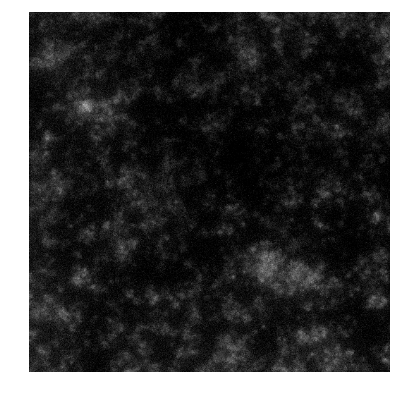

In [233]:
#B06
fh_xls='../../../data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleach10minB06.xlsx'
nd_dh='../../../data/yeast_gfp_half_life/data/160305_bleachto60ormore/160305_bleachchase_bleach10min/20160305_234331_875'
data_job=pd.read_excel(fh_xls,'JobView')
nd_fns=np.sort(data_job['File Name'].unique())
# nd2kins(nd_fns,nd_dh)
nd2vid(nd_fns,nd_dh)

In [18]:
#../tests/test.xlsx
fh_xls='../test/test.xlsx'
data_job=pd.read_excel(fh_xls,'JobView')
nd_dh="/media/Transcend/20160219_000356_267"
data_fns=pd.pivot_table(data_job,values='File Name',index='Loop_bleach Index',columns='Well Name', aggfunc=lambda x: x.iloc[0])
wells=[str(x) for x in list(data_job['Well Name'].unique())]
wells.sort()
wells_b, wells_u =wells[::2],wells[1::2]
pt00s=range(24)
for rowi in range(2,16):
    for coli in range(12):
        pt00s.append(coli)    
info_pt00s=pd.DataFrame({'well' : wells_b, \
                        'pt00': pt00s})
info_pt00s=info_pt00s.set_index('well')
time=np.array(range(24))*2
data_num_kin=pd.DataFrame(columns=wells)
data_num_kin.loc[:,'time']=time
diff_df=pd.DataFrame(columns=wells_b)
diff_df.loc[:,'time']=time
diff_fitted_df=pd.DataFrame(columns=wells_b)
diff_fitted_df.loc[:,'time']=time
rateofrecov_df=pd.DataFrame(index=wells_b,columns=['rateofrecov'])
rateofrecov_df.index.name='smp_well'

In [16]:
wells=['A04']#['A04','B04','A24','B24','A06','B06']
for well in wells:
    nd_fns=np.sort(data_fns[well].dropna().unique())
    kins_mean=nd2kins(nd_fns,nd_dh)
    
#     nd2vid(nd_fns,nd_dh)
#     kins_mean.to_csv('%s_%s_means.csv' % (fh_xls,well))

In [17]:
for welli in range(len(wells_b)):   
    print wells_b[welli]
    data_num_kin.loc[:,wells_b[welli]]     =data2diff(data_num,wells_b[welli],wells_u[welli],info_pt00s)[0]
    data_num_kin.loc[:,wells_u[welli]]     =data2diff(data_num,wells_b[welli],wells_u[welli],info_pt00s)[1]
    diff_df.loc[:,wells_b[welli]]          =data2diff(data_num,wells_b[welli],wells_u[welli],info_pt00s)[2]
#background correction
diff_df_blanks=diff_df[['O13','O15','O17','O19','O21','O23','P13','P15','P17','P19','P21','P23']]


0     3227.284836
1     3219.211288
2     3228.245422
3     3232.234131
4     3227.812988
5     3237.112579
6     3257.570786
7     3242.634735
8     3265.001068
9     3270.218033
10    3255.590714
11    3275.242737
12    3269.349014
13    3288.857239
14    3299.465820
15    3326.657394
16    3305.600174
17    3323.546814
18    3336.261353
19    3338.323669
20    3347.269196
21    3356.033783
22    3367.770905
23    3379.234375
dtype: float64

In [191]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *

In [240]:
arr_list=nd2arr_list(nd_dh,nd_fns)

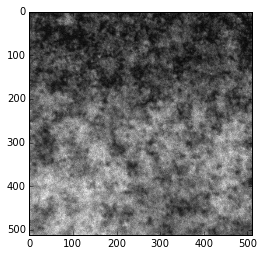

In [241]:
imshow(arr_list[0],cmap='gray')

In [225]:
arr_list[4][0,0]

2614

In [230]:
np.arange(2,len(arr_list)+1)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

In [227]:
len(arr_list)

24